## 対応の無い標本のt検定

異なる母集団から無作為抽出された2つの標本にてついて、標本平均が等しいかどうか？を検定する。

In [43]:
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')

# Libraries
import pandas as pd
import numpy as np
np.random.seed(111)

# scipy
from scipy import stats
# graph
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(111)

# scripts
import utils as u

In [44]:
# graph setting
u.graph_setting()

### データセット

In [45]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

In [46]:
# scikit-learnに用意されている、糖尿病患者のデータセットを使う
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

# diabetesのデータセットは、辞書型で格納されているので、扱いやすいようにpandasのデータフレームに変換する。
# 各特徴データ
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# ラベル, 種類のデータ。各数値ラベルを名前に置き換えて加える。
df["target"] = diabetes.target

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [47]:
# データセットの準備
# 標準化されている'age'のパラメータで、0以上と0未満で標本を分け、20サンプルずつ標本抽出する。
df_1 = df[df["age"]>=0].sample(20, random_state=111).reset_index(drop=True)
df_2 = df[df["age"]<0].sample(30, random_state=111).reset_index(drop=True)

# dataset 1, and 2, 1年後の糖尿病の進行度を示す値の目的変数を値とする。データサイズを最大の方に合わせる
values1 = df_1["bmi"].values
values2 = df_2["bmi"].values

values1, values2

(array([-0.03638469, -0.00836158, -0.04069594, -0.03854032,  0.08864151,
        -0.02129532, -0.03854032, -0.00405033, -0.06332999, -0.02452876,
        -0.02129532,  0.07139652,  0.02720622,  0.01211685,  0.09295276,
        -0.02991782, -0.00836158,  0.05954058,  0.11127556,  0.01966154]),
 array([ 0.00457217,  0.06061839, -0.06440781, -0.046085  ,  0.00241654,
        -0.02237314,  0.0433734 , -0.06979687,  0.09618619, -0.046085  ,
        -0.06117437, -0.01698407,  0.07139652, -0.02345095, -0.02345095,
        -0.0902753 , -0.0105172 ,  0.17055523, -0.00728377, -0.01159501,
         0.00564998, -0.03315126, -0.01806189, -0.01590626, -0.07518593,
        -0.04824063, -0.03854032,  0.05415152, -0.046085  ,  0.08540807]))

### 問題設定

- ある年齢を基準で2標本の糖尿病患者グループを作り、BMIを計測する。<br>
- 取得したデータは、標本1は20人、標本2は30人を抽出したものとする。<br>
- それぞれの年齢帯におけるBMI平均値に差があるといえるか？を統計的に検定する。<br>
->データセットは元のdiabetesデータを、標準化された0を基準に2グループに分けたデータから、それぞれ20サンプルを抽出したデータを取り扱う。<br>

帰無仮説：年齢帯によって、BMIの平均値は変わらない。<br>
対立仮説：年齢帯によって平均値が異なる。<br>
優位水準α=5%(両側)とし判断する。<br>

### データをグラフ確認

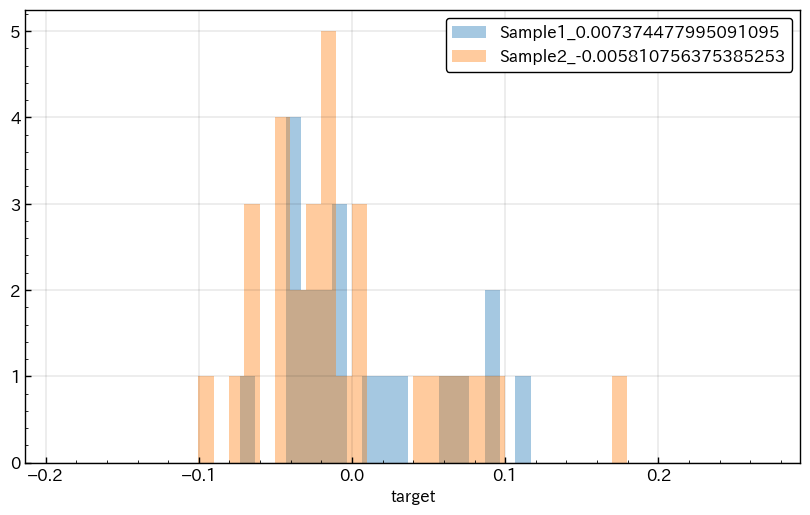

In [48]:
# distplot
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(values1, bins=np.arange(np.min(values1)-0.1, np.max(values1)+0.1, 0.01), kde=False, ax=ax, label=f"Sample1_{np.mean(values1)}")
sns.distplot(values2, bins=np.arange(np.min(values2)-0.1, np.max(values2)+0.1, 0.01), kde=False, ax=ax, label=f"Sample2_{np.mean(values2)}")
ax.set_xlabel("target")
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


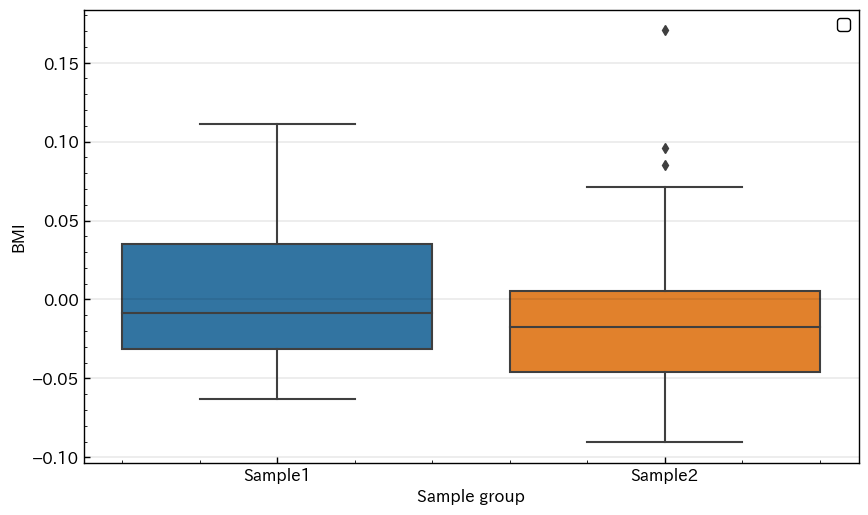

In [50]:
# box plot
fig, ax = plt.subplots(figsize=(10,6))

data = pd.concat([
       pd.DataFrame({"Sample":["Sample1" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["Sample2" for i in range(len(values2))],
                     "Values":values2})
       ]).reset_index(drop=True)

sns.boxplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("BMI")
ax.legend()

# 母分散が等しい前提でt検定

### (1)統計量を求めながらt値を計算する

In [90]:
# Function
def calc_tvalue(values1:list, values2:list)->float:
    '''
    tを計算する

    Args
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        t : 計算されたt値を返す。
    '''

    # calc mean
    m_1, m_2 = np.mean(values1), np.mean(values2)
    # calc std, 母分散が等しいと仮定。合わせたデータで不偏標本標準偏差を使う
    s = np.std(np.concatenate([np.array(values1), np.array(values2)]), ddof=1)
    # dataset count
    n_1, n_2 = len(values1), len(values2)

    # calc standard error
    se = np.sqrt(s**2*(1/n_1 + 1/n_2))

    # t value
    t = (m_1 - m_2) / se

    # print each value
    print(f"Average value, sample1 / sample2 : {m_1}/{m_2}")
    print(f"Standard error : {se}")
    print(f"t value : {t}")

    return t

In [93]:
# calculate t value
t = calc_tvalue(values1=values1, values2=values2)
t

Average value, sample1 / sample2 : 0.007374477995091095/-0.005810756375385253
Standard error : 0.01603550003918475
t value : 0.8222527728013831


0.8222527728013831

In [94]:
# 両側信頼係数のt値を求める。

# 自由度
d = len(values1) + len(values2) - 2
# 片側優位水準
alpha = 0.025

# scipy.statsを使って計算する。
t_thre = stats.t.ppf(1 - alpha/2, d)
print(t_thre)

2.313899134089438


### 判定
- t値は0.822で、優位水準5%の片側2.5%点の値2.31より小さい。よって帰無仮説は棄却されない。<br>
-> 差は無い

### (2) scipy.stats.ttest_ind()関数を使って計算する。

In [95]:
t_value, p_value = stats.ttest_ind(a=values1, b=values2, alternative="two-sided", equal_var=True)
t_value, p_value

(0.8194924848043104, 0.41655608593997484)

### 判定
- p値は0.417と優位水準5%より大きい。よって帰無仮説は棄却されない。<br>
-> 差は無い

### グラフ確認
t分布表を見て、値の関係をイメージする。

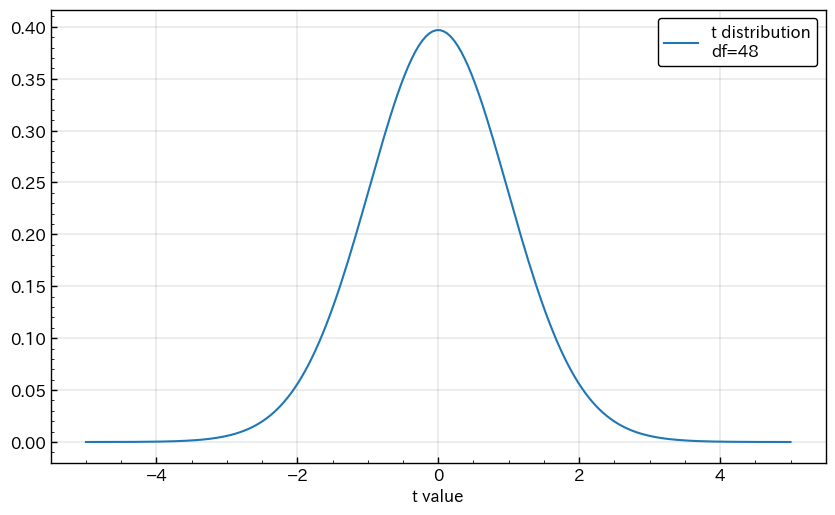

In [96]:
# t分布サンプリング
t_range = np.linspace(-5,5,200)
t_value_ar = []
for i in t_range:
    t_value_ar.append(stats.t.pdf(x=i, df=len(values1)+len(values2)-2))

# plot
plt.figure(figsize=(10,6))
plt.plot(t_range, t_value_ar, label="t distribution\ndf={}".format(len(values1)+len(values2)-2))
plt.xlabel("t value")
plt.legend()

## 標本数を増やした場合を考え、同様の検定を行う

- 取得したデータを、標本1は150人、標本2は200人を抽出したものとする。

In [56]:
# データセットの準備
# 標準化されている'age'のパラメータで、0以上と0未満で標本を分け、20サンプルずつ標本抽出する。
df_1 = df[df["age"]>=0].sample(150, random_state=111).reset_index(drop=True)
df_2 = df[df["age"]<0].sample(200, random_state=111).reset_index(drop=True)

# dataset 1, and 2, 1年後の糖尿病の進行度を示す値の目的変数を値とする。データサイズを最大の方に合わせる
values1 = df_1["bmi"].values
values2 = df_2["bmi"].values

values1, values2

(array([-0.03638469, -0.00836158, -0.04069594, -0.03854032,  0.08864151,
        -0.02129532, -0.03854032, -0.00405033, -0.06332999, -0.02452876,
        -0.02129532,  0.07139652,  0.02720622,  0.01211685,  0.09295276,
        -0.02991782, -0.00836158,  0.05954058,  0.11127556,  0.01966154,
        -0.02237314, -0.00405033, -0.03638469,  0.01750591,  0.02612841,
         0.05954058, -0.04392938, -0.02560657, -0.03530688,  0.03367309,
        -0.00620595, -0.01698407, -0.046085  , -0.00728377, -0.00620595,
         0.05954058,  0.00457217, -0.00512814,  0.03582872,  0.02073935,
        -0.03099563, -0.01267283,  0.04552903, -0.00728377,  0.01211685,
         0.02181716, -0.02021751, -0.02129532, -0.02884001, -0.03207344,
        -0.00189471,  0.07678558, -0.04500719,  0.05846277,  0.02289497,
         0.12313149, -0.06440781,  0.0250506 ,  0.0347509 , -0.02021751,
        -0.03961813, -0.00297252,  0.06169621,  0.03906215,  0.01427248,
        -0.046085  , -0.03207344,  0.00672779, -0.0

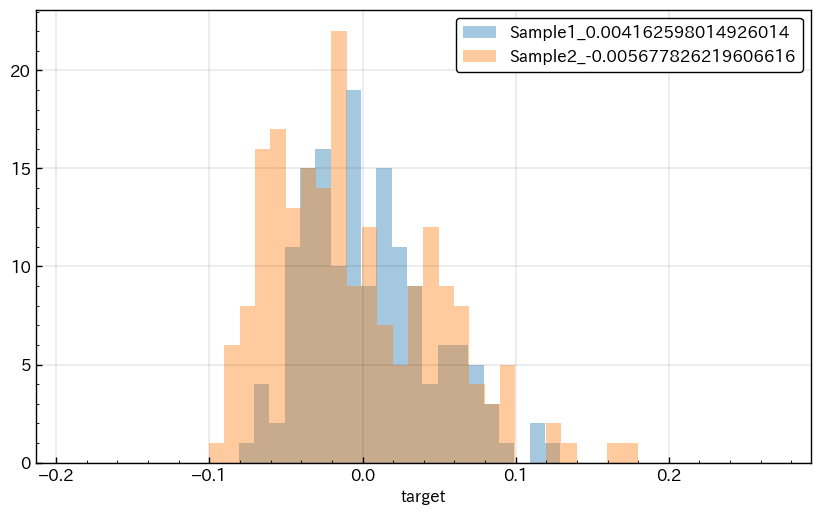

In [57]:
# distplot
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(values1, bins=np.arange(np.min(values1)-0.1, np.max(values1)+0.1, 0.01), kde=False, ax=ax, label=f"Sample1_{np.mean(values1)}")
sns.distplot(values2, bins=np.arange(np.min(values2)-0.1, np.max(values2)+0.1, 0.01), kde=False, ax=ax, label=f"Sample2_{np.mean(values2)}")
ax.set_xlabel("target")
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


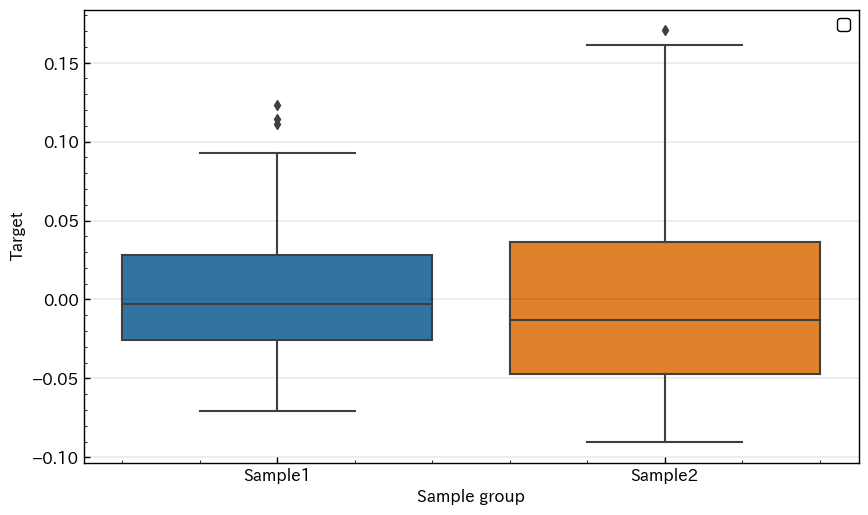

In [58]:
# box plot
fig, ax = plt.subplots(figsize=(10,6))

data = pd.concat([
       pd.DataFrame({"Sample":["Sample1" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["Sample2" for i in range(len(values2))],
                     "Values":values2})
       ]).reset_index(drop=True)

sns.boxplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("Target")
ax.legend()

In [59]:
# calculate t value
t = calc_tvalue(values1=values1, values2=values2)
t

Average value, sample1 / sample2 : 0.004162598014926014/-0.005677826219606616
Standard error : 0.005031210126452502
t value : 1.9558762180881317


1.9558762180881317

### scipy.stats.ttest_ind()関数を使って計算する。

In [104]:
t_value, p_value = stats.ttest_ind(a=values1, b=values2, alternative="two-sided", equal_var=True)
t_value, p_value

(1.8842437808010193, 0.06036533523967504)

### 判定
- p値は0.06と優位水準5%より大きい。よって帰無仮説が棄却される。<br>
-> 差はある。<br>

- もし優位水準10%とした場合は、帰無仮説を棄却できる。<br>
-> この場合は、差はありと判定される

<u>標本数によって母集団からのランダムサンプリングでも、標準誤差の値が変わる事により、t値の値が変化する。<br>
<u>それにより、統計的な判定の結果が変わる。

### t分布のグラフ確認
t分布表を見て、値の関係をイメージする。<br>

初めの検定時：標本数20+30=50より、自由度48のt分布に対してt値が0.819<br>
2回目の検定時：標本数150+200=350より、自由度348のt分布に対してt値が1.884<br>

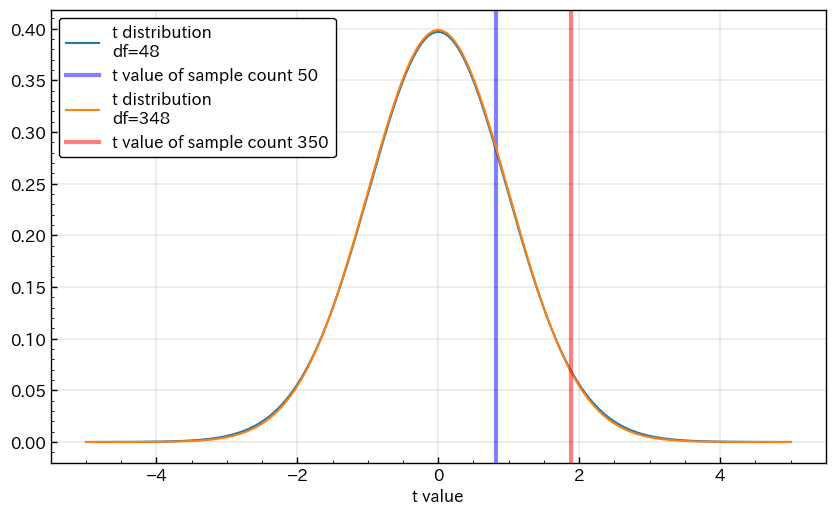

In [66]:
# t分布サンプリング
t_range = np.linspace(-5,5,200)
t_value_ar_1 = []
t_value_ar_2 = []
for i in t_range:
    t_value_ar_1.append(stats.t.pdf(x=i, df=48))
    t_value_ar_2.append(stats.t.pdf(x=i, df=348))


fig, ax = plt.subplots(figsize=(10,6))
# plot
ax.plot(t_range, t_value_ar_1, label="t distribution\ndf={}".format(48))
# t value
ax.axvline(x=0.819, ymin=0, ymax=1, color="blue", lw=3, linestyle="-", alpha=0.5, label="t value of sample count 50")

# plot
ax.plot(t_range, t_value_ar_2, label="t distribution\ndf={}".format(348))
ax.axvline(x=1.884, ymin=0, ymax=1, color="red", lw=3, linestyle="-", alpha=0.5, label="t value of sample count 350")
ax.set_xlabel("t value")
ax.legend()

# 母分散が異なる前提でt検定➡ウェルチのt検定

- データは、標本1は150人、標本2は200人を抽出したものとして検定する。<br>

In [98]:
# データセットの準備
# 標準化されている'age'のパラメータで、0以上と0未満で標本を分け、20サンプルずつ標本抽出する。
df_1 = df[df["age"]>=0].sample(150, random_state=111).reset_index(drop=True)
df_2 = df[df["age"]<0].sample(200, random_state=111).reset_index(drop=True)

# dataset 1, and 2, 1年後の糖尿病の進行度を示す値の目的変数を値とする。データサイズを最大の方に合わせる
values1 = df_1["bmi"].values
values2 = df_2["bmi"].values

values1, values2

(array([-0.03638469, -0.00836158, -0.04069594, -0.03854032,  0.08864151,
        -0.02129532, -0.03854032, -0.00405033, -0.06332999, -0.02452876,
        -0.02129532,  0.07139652,  0.02720622,  0.01211685,  0.09295276,
        -0.02991782, -0.00836158,  0.05954058,  0.11127556,  0.01966154,
        -0.02237314, -0.00405033, -0.03638469,  0.01750591,  0.02612841,
         0.05954058, -0.04392938, -0.02560657, -0.03530688,  0.03367309,
        -0.00620595, -0.01698407, -0.046085  , -0.00728377, -0.00620595,
         0.05954058,  0.00457217, -0.00512814,  0.03582872,  0.02073935,
        -0.03099563, -0.01267283,  0.04552903, -0.00728377,  0.01211685,
         0.02181716, -0.02021751, -0.02129532, -0.02884001, -0.03207344,
        -0.00189471,  0.07678558, -0.04500719,  0.05846277,  0.02289497,
         0.12313149, -0.06440781,  0.0250506 ,  0.0347509 , -0.02021751,
        -0.03961813, -0.00297252,  0.06169621,  0.03906215,  0.01427248,
        -0.046085  , -0.03207344,  0.00672779, -0.0

### (1)統計量を求めながらt値を計算する

In [99]:
# Function
def calc_tvalue_weltch(values1:list, values2:list)->float:
    '''
    tを計算する

    Args
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        t : 計算されたt値を返す。
    '''

    # calc mean
    m_1, m_2 = np.mean(values1), np.mean(values2)
    # calc std, 不偏分散を使う
    s_1, s_2 = np.var(values1, ddof=1), np.var(values2, ddof=1)
    # dataset count
    n_1, n_2 = len(values1), len(values2)

    # calc standard error
    se = np.sqrt((s_1**2/n_1) + (s_2**2/n_2))

    # t value
    t = (m_1 - m_2) / se

    # print each value
    print(f"Average value, sample1 / sample2 : {m_1}/{m_2}")
    print(f"Standard error : {se}")
    print(f"t value : {t}")

    return t

In [100]:
# calculate t value
t = calc_tvalue(values1=values1, values2=values2)
t

Average value, sample1 / sample2 : 0.004162598014926014/-0.005677826219606616
Standard error : 0.005241526676250299
t value : 1.8773965759098847


1.8773965759098847

In [101]:
# 両側信頼係数のt値を求める。

# 自由度
d = len(values1) + len(values2) - 2
# 片側優位水準
alpha = 0.025

# scipy.statsを使って計算する。
t_thre = stats.t.ppf(1 - alpha/2, d)
print(t_thre)

2.2511429423460063


### 判定
- t値は1.88で、優位水準5%の片側2.5%点の値2.31より小さい。よって帰無仮説は棄却されない。<br>
-> 差は無い

### (2) scipy.stats.ttest_ind()関数を使って計算する。

In [102]:
t_value, p_value = stats.ttest_ind(a=values1, b=values2, alternative="two-sided", equal_var=False)
t_value, p_value

(1.9558762180881317, 0.05127987367710076)

### 判定
- p値は0.051と優位水準5%より大きい、よって帰無仮説が棄却される。<br>
-> 差はある。<br>

- もし優位水準10%とした場合は、帰無仮説を棄却できる。<br>
-> この場合は、差はありと判定される

<u>母分散が等しいかの前提によって、t値の値が変化する。<br>
<u>それにより、統計的な判定の結果が変わる。